In [ ]:
!pip install torchaudio
!pip install librosa
!pip install jiwer
!pip install ffmpeg-python

In [ ]:
# credits to: https://github.com/voidful/huggingface_notebook/blob/main/xlsr_gpt.ipynb
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import wave
from scipy.io.wavfile import read as wav_read
import io
import numpy as np
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);

function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

def write_wav(f, sr, x, normalized=False):
    f = wave.open(f, "wb")
    f.setnchannels(1)
    f.setsampwidth(2)
    f.setframerate(sr)
    
    wave_data = x.astype(np.short)
    f.writeframes(wave_data.tobytes())
    f.close()

def get_audio():
  global hnum

  # call microphone
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])

  process = (ffmpeg
      .input('pipe:0')
      .output('pipe:1', format='wav')
      .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)

  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]
  sr, audio = wav_read(io.BytesIO(riff))
  # save
  human_sound_file = "demo.wav"
  write_wav(human_sound_file, sr, audio)

  return human_sound_file

In [ ]:
get_audio()

'demo.wav'

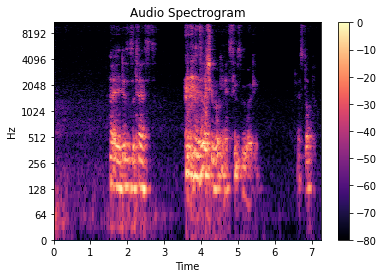

In [ ]:
import librosa
import librosa.display
import IPython.display as ipd
file="demo.wav"
audio, sample_rate = librosa.load(file)
ipd.Audio(file, rate=sample_rate)


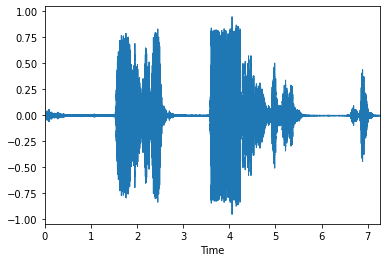

In [ ]:
import librosa
import librosa.display
import IPython.display as ipd
file="demo.wav"
audio, sample_rate = librosa.load(file)
# ---
import numpy as np
import matplotlib.pyplot as plt

_ = librosa.display.waveplot(audio)

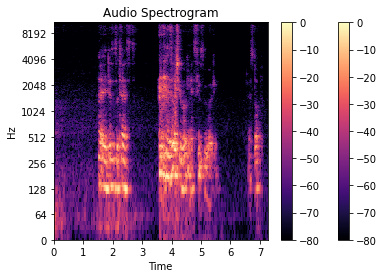

In [ ]:
import librosa
import librosa.display
import IPython.display as ipd
file="demo.wav"
audio, sample_rate = librosa.load(file)

# Get spectrogram using Librosa's Short-Time Fourier Transform (stft)
spec = np.abs(librosa.stft(audio))
spec_db = librosa.amplitude_to_db(spec, ref=np.max)  # Decibels

# Use log scale to view frequencies
librosa.display.specshow(spec_db, y_axis='log', x_axis='time')
plt.colorbar()
plt.title('Audio Spectrogram');

plt.show()

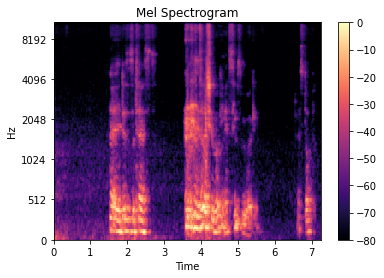

In [ ]:

import librosa
import librosa.display
import IPython.display as ipd
file="demo.wav"
audio, sample_rate = librosa.load(file)

# Plot the mel spectrogram of our sample
mel_spec = librosa.feature.melspectrogram(audio, sr=sample_rate)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

librosa.display.specshow(
    mel_spec_db, x_axis='time', y_axis='mel')
plt.colorbar()
plt.title('Mel Spectrogram');



# Install NeMo and its dependencies

In [ ]:
## Install dependencies
!pip install wget
!apt-get install sox libsndfile1 ffmpeg
!pip install unidecode

# ## Install NeMo
!python -m pip install nemo_toolkit['asr']==1.1.0

## Install TorchAudio
!pip install torchaudio>=0.6.0 -f https://download.pytorch.org/whl/torch_stable.html

# use pretrained model -> TODO

In [ ]:
import nemo.collections.asr as nemo_asr
restored_model = nemo_asr.models.EncDecSpeakerLabelModel.load_from_checkpoint("lang_clf_model.ckpt")
restored_model.eval()
print(restored_model)

In [ ]:
get_audio()
file="demo.wav"
audio, sample_rate = librosa.load(file)

print(infer_signal(restored_model,audio))